## Description
The Titanic data provides information about the survival of passengers on the Titanic, as well as characteristics about the passengers such as age and ticket class. Using this data, the tutorial will establish a model for predicting whether a given passenger would have survived the sinking of the Titanic.
## Resources
- https://www.kaggle.com/kernelgenerator/titanic-tutorial-for-beginners-part-1
- https://code.visualstudio.com/docs/python/data-science-tutorial

In [293]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import re # for Regular Expressions
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from statistics import mode
from sklearn.model_selection import KFold, cross_val_score # for the cross-validation
from sklearn.preprocessing import LabelEncoder # Encoding categorical data
from sklearn.preprocessing import StandardScaler # feature scaling, normalization
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline 

# load training and test data
titanic = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [180]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [66]:
titanic.describe()
# see the max someone paid for a ticket was 512.3292 
# the minimum price was 0 pounds
# there is missing data since the count is lower for some cols
# the oldest passenger was 80 years old
# the youngest was only .42 years old (about 5 months).

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [67]:
titanic.Sex[titanic.Sex == 'male'].count()

577

Number of males:  577
Number of females:  314


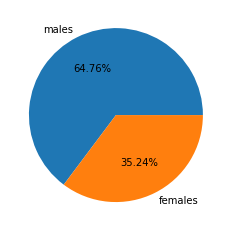

In [68]:
males = titanic.Sex[titanic.Sex == 'male'].count()
females = titanic.Sex[titanic.Sex == 'female'].count()

print("Number of males: ",males)
print("Number of females: ",females)
plt.pie([males, females], autopct = '%.2f%%',labels=("males","females"))
plt.show()

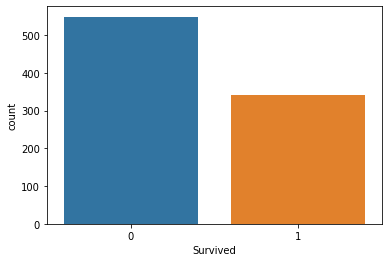

In [69]:
#Visualize the count of number of survivors
sns.countplot(titanic['Survived'],label="Count")

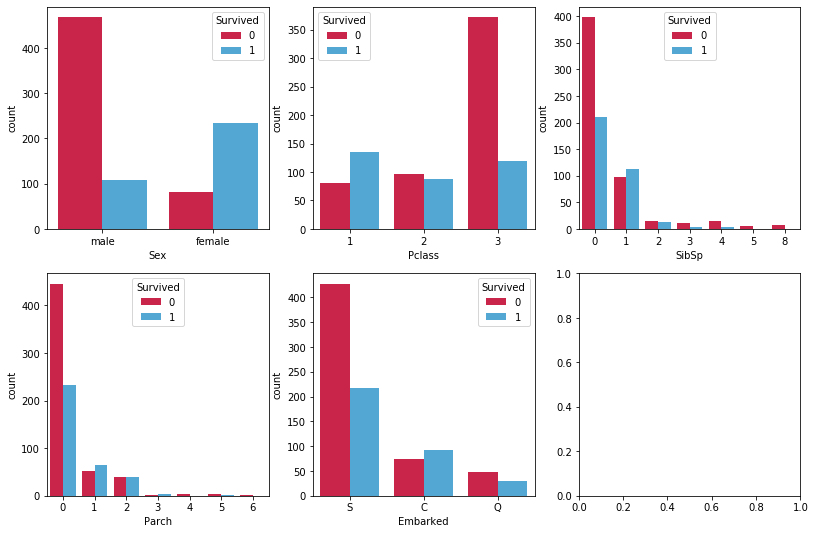

In [70]:
columns = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']
rows = 2
cols = 3

# fig is figure, the top level container for all the plot elements.
# axs is the list of subplots, an array of Axes objects
fig, axs = plt.subplots(rows, cols, figsize = (cols * 4.5, rows * 4.5) )
fig
for r in range(0, rows):
    for c in range(0, cols):
        i = r * cols + c # to address the ith subplot
        if i < (rows * cols)-1:
            subplot = axs[r][c]   # select the current subplot to draw into
            sns.countplot(titanic[columns[i]], hue=titanic['Survived'], ax=subplot, palette=["#e40a3b", "#3daee9"])
            subplot.legend(title='Survived', loc='best')

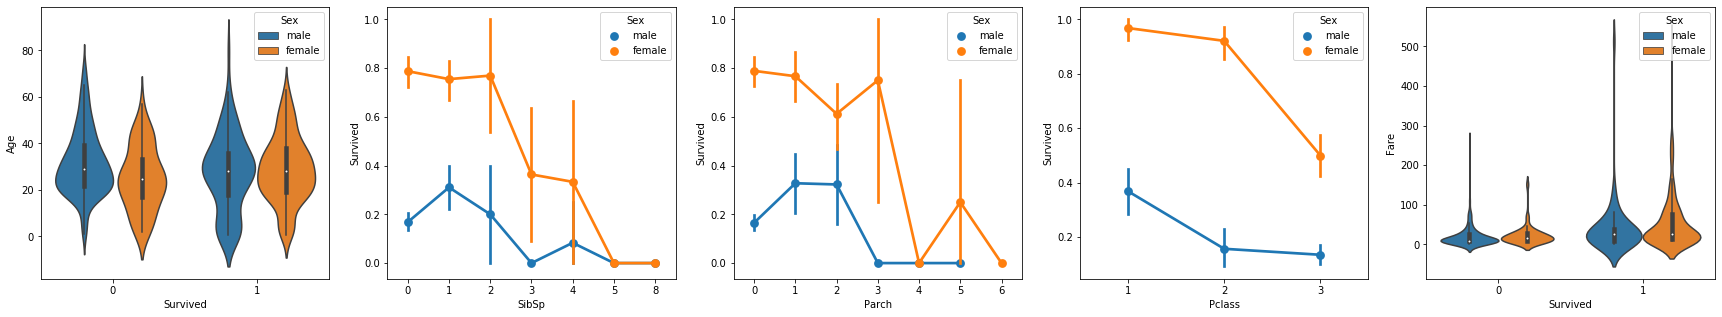

In [71]:
fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="Survived", y="Age", hue="Sex", data=titanic, ax=axs[0])
sns.pointplot(x="SibSp", y="Survived", hue="Sex", data=titanic, ax=axs[1])
sns.pointplot(x="Parch", y="Survived", hue="Sex", data=titanic, ax=axs[2])
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=titanic, ax=axs[3])
sns.violinplot(x="Survived", y="Fare", hue="Sex", data=titanic, ax=axs[4])

In [72]:
# create a table where columns are Class, rows are Sex
# then in each block summarize by Survival rates
titanic.pivot_table('Survived', index="Sex", columns="Pclass")

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


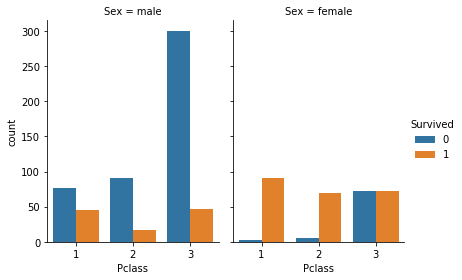

In [73]:
# see visually who survived based on class and sex
sns.catplot(x="Pclass", hue="Survived", col="Sex",
                data=titanic, kind="count",
                height=4, aspect=.7);

In [74]:
# Count survived females traveling on the first class
survived_first_class_females = titanic.loc[(titanic.Sex == 'female') 
            & (titanic.Pclass == 1)
            & (titanic.Survived == 1)].shape[0]

# Count females who did not survive traveling on the first class
non_survived_first_class_females = titanic.loc[(titanic.Sex == 'female') 
            & (titanic.Pclass == 1)
            & (titanic.Survived == 0)].shape[0]

print('Females who survived on first class: ', survived_first_class_females)
print('Females who did not survive on first class: ', non_survived_first_class_females)



Females who survived on first class:  91
Females who did not survive on first class:  3


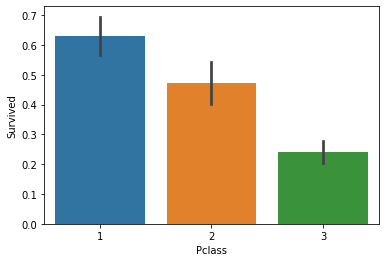

In [75]:
#Plot the survival rate of each class.
sns.barplot(x='Pclass', y='Survived', data=titanic)

In [76]:
#Look at survival rate by sex, age and class
age = pd.cut(titanic['Age'], [0, 18, 80])
titanic.pivot_table('Survived', ['Sex', age], 'Pclass')

Pclass                  1         2         3
Sex    Age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

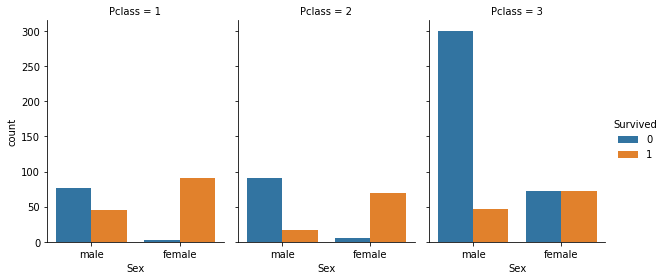

In [77]:
# see visually who survived based on class and sex
sns.catplot(x='Sex', hue='Survived', col="Pclass",
                data=titanic, kind="count",
                height=4, aspect=.7);

Text(0.5, 1.0, 'Price for each class')

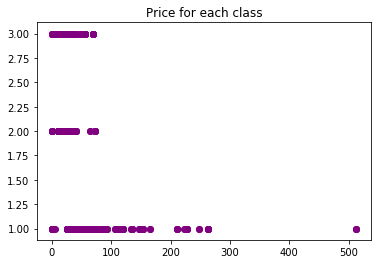

In [78]:
plt.scatter(titanic['Fare'], titanic['Pclass'], color='purple')
plt.title('Price for each class')

In [79]:
#Count the empty (NaN, NAN, na) values in each column 
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [80]:
#Remove the rows with missing values
titanic = titanic.dropna(subset =['Embarked', 'Age'])

In [81]:
# check data types
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [82]:
titanic.head

<bound method NDFrame.head of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
885          886         0       3   
886          887         0       2   
887          888         1       1   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                     

In [83]:
# Print the unique values in columns with categorical values
print(titanic['Sex'].unique())
print(titanic['Embarked'].unique())

['male' 'female']
['S' 'C' 'Q']


In [84]:
labelencoder = LabelEncoder()

# Encode sex column
titanic.Sex.replace({'male': 1, 'female': 0}, inplace=True) # this is very neat and efficient replacement
# titanic.loc[:,'Sex'] = labelencoder.fit_transform(titanic.loc[:,'Sex'].values)

# Encode embarked column, with this more advanced Label Encoder method
titanic.loc[:,'Embarked'] = labelencoder.fit_transform(titanic.loc[:,'Embarked'].values)

In [85]:
# Print again the unique values in columns with categorical values
print(titanic['Sex'].unique())
print(titanic['Embarked'].unique())

[1 0]
[2 0 1]


In [86]:
# now that Sex and Embarked is encoded correlations can be explored between variables and survival
titanic.corr().abs()[["Survived"]]

,Survived
PassengerId,0.029526
Survived,1.000000
Pclass,0.356462
Sex,0.536762
Age,0.082446
SibSp,0.015523
Parch,0.095265
Fare,0.266100
Embarked,0.181979


In [87]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2


In [89]:
# Feature engineering
# Check if for a given passenger, the number of sibsp and parch is greater than 0
# If so, we can then say that they had a relative on board
titanic['Relatives'] = titanic.apply (lambda row: int((row['SibSp'] + row['Parch']) > 0), axis=1)
test['Relatives'] = titanic.apply (lambda row: int((row['SibSp'] + row['Parch']) > 0), axis=1)

titanic.corr().abs()[["Survived"]]
# From the correlation result, we can see that having a relative on board has a higher correlation with survival
# Than checking how many relatives the passenger had

,Survived
PassengerId,0.029526
Survived,1.000000
Pclass,0.356462
Sex,0.536762
Age,0.082446
SibSp,0.015523
Parch,0.095265
Fare,0.266100
Embarked,0.181979
Relatives,0.199741


In [92]:
# Split the data into independent 'X' and dependent 'Y' variables
# Drop all non relevant columns, and the ones which have no strong correlation to survival
# Since we now have Relatives column, we can drop SibSp and Parch too
X = titanic.drop(['PassengerId', 'Survived', 'SibSp', 'Parch', 'Name', 'Cabin', 'Ticket'], axis=1)
Y = titanic.Survived # select id column

In [98]:
# Split the dataset into 80% Training set and 20% Testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [101]:
# Feature Scaling, this is essential to train the models fast
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [156]:
def models(X_train, Y_train):

    # Logistic Regression
    logReg = LogisticRegression(max_iter = 1000000, random_state=0)
    logReg.fit(X_train, Y_train)
    
    # K Nearest Neighbours
    knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
    knn.fit(X_train, Y_train)
    
    # Support Vector Machine (linear kernel)
    svc_lin = SVC(kernel='linear', random_state=0)
    svc_lin.fit(X_train, Y_train)
    
    # Support Vector Machine (RBF kernel)
    svc_rbf = SVC(kernel='rbf', random_state=0)
    svc_rbf.fit(X_train, Y_train)
    
    # Gaussian Naive Bayes
    gauss = GaussianNB()
    gauss.fit(X_train, Y_train)
    
    # Decision Tree
    tree = DecisionTreeClassifier(criterion='entropy', random_state=0)
    tree.fit(X_train, Y_train)
    
    # Random Forest Classifier
    forest = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
    forest.fit(X_train, Y_train)
    
    #Print training accuracy for each model
    print('[0] Logistic Regression Training Accuracy', logReg.score(X_train, Y_train))
    print('[1] K Nearest Neighbors Training Accuracy', knn.score(X_train, Y_train))
    print('[2] SVC Linear Training Accuracy', svc_lin.score(X_train, Y_train))
    print('[3] SVC RBF Training Accuracy', svc_rbf.score(X_train, Y_train))
    print('[4] Gaussian NB Training Accuracy', gauss.score(X_train, Y_train))
    print('[5] Decision Tree Training Accuracy', tree.score(X_train, Y_train))
    print('[6] Random Forest Training Accuracy', forest.score(X_train, Y_train))
    
    return logReg, knn, svc_lin, svc_rbf, gauss, tree, forest


In [157]:
model = models(X_train, Y_train)

[0] Logistic Regression Training Accuracy 0.789103690685413
[1] K Nearest Neighbors Training Accuracy 0.8611599297012302
[2] SVC Linear Training Accuracy 0.7768014059753954
[3] SVC RBF Training Accuracy 0.8295254833040422
[4] Gaussian NB Training Accuracy 0.7609841827768014
[5] Decision Tree Training Accuracy 0.9929701230228472
[6] Random Forest Training Accuracy 0.9859402460456942


In [159]:
for i in range( len(model) ):
    print(f'Model[{i}] Testing Accuracy:' , model[i].score(X_test, Y_test))
# Logistic Regression and Random Forest performs the best on the testing data

Model[0] Testing Accuracy: 0.8111888111888111
Model[1] Testing Accuracy: 0.7552447552447552
Model[2] Testing Accuracy: 0.7902097902097902
Model[3] Testing Accuracy: 0.7902097902097902
Model[4] Testing Accuracy: 0.7412587412587412
Model[5] Testing Accuracy: 0.7972027972027972
Model[6] Testing Accuracy: 0.7902097902097902


In [175]:
# Neural Network
nn = Sequential()
nn.add(Dense(12, kernel_initializer = 'uniform', activation = 'relu', input_dim = 6))
nn.add(Dense(24, kernel_initializer = 'uniform', activation = 'relu'))
nn.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
nn.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(X_train, Y_train, batch_size=64, epochs=250)

Epoch 1/250
569/569 [==============================] - 1s 1ms/step - loss: 0.6925 - accuracy: 0.5870
Epoch 2/250
569/569 [==============================] - 0s 56us/step - loss: 0.6910 - accuracy: 0.6011
Epoch 3/250
569/569 [==============================] - 0s 47us/step - loss: 0.6886 - accuracy: 0.6011
Epoch 4/250
569/569 [==============================] - 0s 46us/step - loss: 0.6845 - accuracy: 0.6292
Epoch 5/250
569/569 [==============================] - 0s 48us/step - loss: 0.6784 - accuracy: 0.7012
Epoch 6/250
569/569 [==============================] - 0s 47us/step - loss: 0.6687 - accuracy: 0.7469
Epoch 7/250
569/569 [==============================] - 0s 46us/step - loss: 0.6562 - accuracy: 0.7645
Epoch 8/250
569/569 [==============================] - 0s 46us/step - loss: 0.6381 - accuracy: 0.7522
Epoch 9/250
569/569 [==============================] - 0s 47us/step - loss: 0.6166 - accuracy: 0.7575
Epoch 10/250
569/569 [==============================] - 0s 47us/step - loss: 0.5909

569/569 [==============================] - 0s 49us/step - loss: 0.4212 - accuracy: 0.8049
Epoch 81/250
569/569 [==============================] - 0s 46us/step - loss: 0.4212 - accuracy: 0.8049
Epoch 82/250
569/569 [==============================] - 0s 45us/step - loss: 0.4207 - accuracy: 0.8049
Epoch 83/250
569/569 [==============================] - 0s 47us/step - loss: 0.4205 - accuracy: 0.8049
Epoch 84/250
569/569 [==============================] - 0s 46us/step - loss: 0.4208 - accuracy: 0.7996
Epoch 85/250
569/569 [==============================] - 0s 42us/step - loss: 0.4204 - accuracy: 0.8067
Epoch 86/250
569/569 [==============================] - 0s 42us/step - loss: 0.4202 - accuracy: 0.8084
Epoch 87/250
569/569 [==============================] - 0s 40us/step - loss: 0.4199 - accuracy: 0.8084
Epoch 88/250
569/569 [==============================] - 0s 49us/step - loss: 0.4202 - accuracy: 0.8067
Epoch 89/250
569/569 [==============================] - 0s 47us/step - loss: 0.4198 - 

569/569 [==============================] - 0s 40us/step - loss: 0.4105 - accuracy: 0.8260
Epoch 160/250
569/569 [==============================] - 0s 52us/step - loss: 0.4105 - accuracy: 0.8243
Epoch 161/250
569/569 [==============================] - 0s 46us/step - loss: 0.4102 - accuracy: 0.8260
Epoch 162/250
569/569 [==============================] - 0s 44us/step - loss: 0.4100 - accuracy: 0.8260
Epoch 163/250
569/569 [==============================] - 0s 48us/step - loss: 0.4103 - accuracy: 0.8278
Epoch 164/250
569/569 [==============================] - 0s 42us/step - loss: 0.4100 - accuracy: 0.8278
Epoch 165/250
569/569 [==============================] - 0s 48us/step - loss: 0.4097 - accuracy: 0.8260
Epoch 166/250
569/569 [==============================] - 0s 44us/step - loss: 0.4096 - accuracy: 0.8260
Epoch 167/250
569/569 [==============================] - 0s 44us/step - loss: 0.4095 - accuracy: 0.8260
Epoch 168/250
569/569 [==============================] - 0s 42us/step - loss: 

569/569 [==============================] - 0s 47us/step - loss: 0.3975 - accuracy: 0.8313
Epoch 238/250
569/569 [==============================] - 0s 48us/step - loss: 0.3970 - accuracy: 0.8330
Epoch 239/250
569/569 [==============================] - 0s 45us/step - loss: 0.3968 - accuracy: 0.8295
Epoch 240/250
569/569 [==============================] - 0s 44us/step - loss: 0.3968 - accuracy: 0.8330
Epoch 241/250
569/569 [==============================] - 0s 42us/step - loss: 0.3966 - accuracy: 0.8313
Epoch 242/250
569/569 [==============================] - 0s 42us/step - loss: 0.3967 - accuracy: 0.8295
Epoch 243/250
569/569 [==============================] - 0s 40us/step - loss: 0.3965 - accuracy: 0.8295
Epoch 244/250
569/569 [==============================] - 0s 44us/step - loss: 0.3964 - accuracy: 0.8313
Epoch 245/250
569/569 [==============================] - 0s 44us/step - loss: 0.3966 - accuracy: 0.8295
Epoch 246/250
569/569 [==============================] - 0s 45us/step - loss: 

In [176]:
nn.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 12)                84        
_________________________________________________________________
dense_44 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 25        
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [177]:
score, acc = nn.evaluate(X_test, Y_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

143/143 [==============================] - 0s 1ms/step
Test score: 0.44560403840525165
Test accuracy: 0.811188817024231


In [165]:
# Get feature importance
forest = model[6]
features = X.columns # select feature columns (PassengerId and Survived is omitted)
forest.feature_importances_
importances = pd.DataFrame({'feature': features, 'importance': np.round(forest.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
importances

,importance
feature,
Fare,0.327
Age,0.317
Sex,0.181
Pclass,0.112
Embarked,0.042
Relatives,0.021


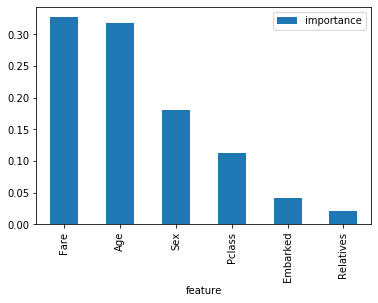

In [166]:
importances.plot.bar()

## Preparing to save and submit results based on best model

In [257]:
# Feature Scaling, this is essential to train the models fast
sc = StandardScaler()
X_full = sc.fit_transform(X)

# Define Neural Network
nn = Sequential()
nn.add(Dense(12, kernel_initializer = 'uniform', activation = 'relu', input_dim = 6))
nn.add(Dense(24, kernel_initializer = 'uniform', activation = 'relu'))
nn.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
nn.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
nn.summary()    

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 12)                84        
_________________________________________________________________
dense_53 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 25        
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [258]:
nn.fit(X_full, Y, batch_size=64, epochs=250)   

Epoch 1/250
712/712 [==============================] - 1s 1ms/step - loss: 0.6925 - accuracy: 0.6039
Epoch 2/250
712/712 [==============================] - 0s 66us/step - loss: 0.6905 - accuracy: 0.6152
Epoch 3/250
712/712 [==============================] - 0s 42us/step - loss: 0.6871 - accuracy: 0.6713
Epoch 4/250
712/712 [==============================] - 0s 46us/step - loss: 0.6810 - accuracy: 0.7219
Epoch 5/250
712/712 [==============================] - 0s 45us/step - loss: 0.6704 - accuracy: 0.7570
Epoch 6/250
712/712 [==============================] - 0s 44us/step - loss: 0.6536 - accuracy: 0.7612
Epoch 7/250
712/712 [==============================] - 0s 47us/step - loss: 0.6312 - accuracy: 0.7697
Epoch 8/250
712/712 [==============================] - 0s 51us/step - loss: 0.6022 - accuracy: 0.7725
Epoch 9/250
712/712 [==============================] - 0s 43us/step - loss: 0.5705 - accuracy: 0.7711
Epoch 10/250
712/712 [==============================] - 0s 48us/step - loss: 0.5404

712/712 [==============================] - 0s 55us/step - loss: 0.4226 - accuracy: 0.8104
Epoch 81/250
712/712 [==============================] - 0s 56us/step - loss: 0.4220 - accuracy: 0.8132
Epoch 82/250
712/712 [==============================] - 0s 63us/step - loss: 0.4221 - accuracy: 0.8146
Epoch 83/250
712/712 [==============================] - 0s 51us/step - loss: 0.4221 - accuracy: 0.8174
Epoch 84/250
712/712 [==============================] - 0s 46us/step - loss: 0.4224 - accuracy: 0.8160
Epoch 85/250
712/712 [==============================] - 0s 50us/step - loss: 0.4221 - accuracy: 0.8174
Epoch 86/250
712/712 [==============================] - 0s 51us/step - loss: 0.4216 - accuracy: 0.8090
Epoch 87/250
712/712 [==============================] - 0s 61us/step - loss: 0.4213 - accuracy: 0.8090
Epoch 88/250
712/712 [==============================] - 0s 56us/step - loss: 0.4211 - accuracy: 0.8118
Epoch 89/250
712/712 [==============================] - 0s 53us/step - loss: 0.4212 - 

712/712 [==============================] - 0s 48us/step - loss: 0.4164 - accuracy: 0.8202
Epoch 160/250
712/712 [==============================] - 0s 47us/step - loss: 0.4167 - accuracy: 0.8174
Epoch 161/250
712/712 [==============================] - 0s 47us/step - loss: 0.4162 - accuracy: 0.8188
Epoch 162/250
712/712 [==============================] - 0s 49us/step - loss: 0.4161 - accuracy: 0.8202
Epoch 163/250
712/712 [==============================] - 0s 52us/step - loss: 0.4159 - accuracy: 0.8174
Epoch 164/250
712/712 [==============================] - 0s 43us/step - loss: 0.4154 - accuracy: 0.8188
Epoch 165/250
712/712 [==============================] - 0s 43us/step - loss: 0.4153 - accuracy: 0.8216
Epoch 166/250
712/712 [==============================] - 0s 45us/step - loss: 0.4152 - accuracy: 0.8202
Epoch 167/250
712/712 [==============================] - 0s 51us/step - loss: 0.4153 - accuracy: 0.8188
Epoch 168/250
712/712 [==============================] - 0s 52us/step - loss: 

712/712 [==============================] - 0s 47us/step - loss: 0.4083 - accuracy: 0.8230
Epoch 238/250
712/712 [==============================] - 0s 47us/step - loss: 0.4089 - accuracy: 0.8258
Epoch 239/250
712/712 [==============================] - 0s 45us/step - loss: 0.4080 - accuracy: 0.8230
Epoch 240/250
712/712 [==============================] - 0s 45us/step - loss: 0.4076 - accuracy: 0.8287
Epoch 241/250
712/712 [==============================] - 0s 45us/step - loss: 0.4080 - accuracy: 0.8244
Epoch 242/250
712/712 [==============================] - 0s 45us/step - loss: 0.4079 - accuracy: 0.8230
Epoch 243/250
712/712 [==============================] - 0s 46us/step - loss: 0.4085 - accuracy: 0.8244
Epoch 244/250
712/712 [==============================] - 0s 48us/step - loss: 0.4074 - accuracy: 0.8258
Epoch 245/250
712/712 [==============================] - 0s 50us/step - loss: 0.4071 - accuracy: 0.8258
Epoch 246/250
712/712 [==============================] - 0s 47us/step - loss: 

In [259]:
predict = nn.predict_classes(X_full)
print(accuracy_score(Y, predict))

0.824438202247191


In [294]:
# prepare test set
labelencoder = LabelEncoder()
test.Sex.replace({'male': 1, 'female': 0}, inplace=True)
test.loc[:,'Embarked'] = labelencoder.fit_transform(test.loc[:,'Embarked'].values)

In [295]:
# Feature Engineering
test['Relatives'] = test.apply(lambda row: int((row['SibSp'] + row['Parch']) > 0), axis=1)

In [296]:
# Select Age and Fare column, and only those columns where value is null
# The fill the nulls with average value

# In Age column Pclass has the highest correlation, so we use that to fill missing values
test.loc[test.Age.isnull(), 'Age'] = test.groupby("Pclass").Age.transform('median')

# In Fare column Pclass has also the highest correlation, so we use that to fill missing values
test.loc[test.Fare.isnull(), 'Fare'] = test.groupby("Pclass").Fare.transform('mean')

# test['Age'] = test.groupby("Pclass")['Age'].transform(lambda x: x.fillna(x.median()))
# test['Fare'] = test.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))

In [297]:
# Split the data into independent 'X' and dependent 'Y' variables
# Drop all non relevant columns, and the ones which have no strong correlation to survival
# Since we now have Relatives column, we can drop SibSp and Parch too
test_x = test.drop(['PassengerId', 'Name', 'SibSp', 'Parch','Ticket', 'Cabin'], axis=1)

In [298]:
test_x.isna().sum()

Pclass       0
Sex          0
Age          0
Fare         0
Embarked     0
Relatives    0
dtype: int64

In [299]:
# Feature Scaling
test_x = sc.transform(test_x)

In [300]:
# Make predictions on test set
test['Survived'] = nn.predict_classes(test_x)

In [301]:
# Create file for submission
test[['PassengerId', 'Survived']].to_csv('data/kaggle_submission_nn.csv', index = False)